In [1]:
import torch
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error
from torch import nn
from torch.optim import SGD
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import scipy
import xgboost as xgb
import math

In [2]:
train = np.load("./data_nature/down_cell_data_10.npy")
train = train[:,:]
label = np.load("./data_nature/label_chirp.npy")
label = label.T[:,:]


In [3]:
X_train, X_test, y_train, y_test = train_test_split(train, label, test_size=0.2, random_state=0)

X_train_final = torch.from_numpy(X_train.astype(np.float32))
y_train_final = torch.from_numpy(y_train.astype(np.float32))
X_test_final = torch.from_numpy(X_test.astype(np.float32))
y_test_final = torch.from_numpy(y_test.astype(np.float32))

train_data = Data.TensorDataset(X_train_final, y_train_final)
test_data = Data.TensorDataset(X_test_final, y_test_final)
train_loader = Data.DataLoader(dataset=train_data, batch_size=32,
                               shuffle=True, num_workers=0)
test_loader = Data.DataLoader(dataset=test_data, batch_size=32,
                               shuffle=True, num_workers=0)

### MLP

In [4]:
### Regular model

class Re_ChirpMLP(nn.Module):

    def __init__(self, n_inputs):
        super(Re_ChirpMLP, self).__init__()
        self.fc1 = nn.Linear(n_inputs, out_features=3000, bias=True)
        self.fc2 = nn.Linear(3000, 2000)
        self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(2000, 1500)
        self.fc4 = nn.Linear(1500, 800)
        self.fc5 = nn.Linear(800, 400)
        self.predict = nn.Linear(400, 249)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = torch.tanh(self.fc5(x))
        outputs = self.predict(x)
        return outputs

In [5]:
### Larger model
class Large_ChirpMLP(nn.Module):

    def __init__(self, n_inputs):
        super(Large_ChirpMLP, self).__init__()
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(n_inputs, out_features=1250, bias=True)
        self.fc2 = nn.Linear(1250, 1000)
        self.fc3 = nn.Linear(1000, 750)
        self.fc4 = nn.Linear(750, 500)
        self.fc5 = nn.Linear(500, 350)
        self.predict = nn.Linear(350, 249)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.dropout(x)
        x = torch.tanh(self.fc5(x))
        outputs = self.predict(x)
        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= Re_ChirpMLP(3199).to(device)

num_epochs = 30
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
loss_func = nn.MSELoss()
train_loss_all = []
test_loss_all = []

In [7]:
### Training Process: 1. Regular model
###                   2. Large model
###                   3. Small model

# for epoch in range(300):
#     epoch_loss = 0.0
#     train_total_out = []
#     for step, (inputs, targets) in enumerate(train_loader):
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer_re.zero_grad()
#         output = model_re(inputs)
#         loss = loss_func(output, targets)
#         loss.backward()
#         optimizer_re.step()
#         epoch_loss += loss.item()
#         train_total_out.append(output)
#         print(f'Epoch [{epoch+1}/{300}], Loss: {loss.item()}')
        
#     avg_epoch_loss = epoch_loss / len(train_loader)
#     train_loss_re.append(avg_epoch_loss) 
for epoch in range(num_epochs):
    
    model.train()
    train_loss = 0.0
    for step, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = loss_func(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader)
    train_loss_all.append(train_loss) 
################################################################
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for step, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, targets)

            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(test_loader)
    test_loss_all.append(test_loss) 

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/30], Train Loss: 8.1804, Test Loss: 7.0098
Epoch [2/30], Train Loss: 6.7569, Test Loss: 6.3881
Epoch [3/30], Train Loss: 6.2297, Test Loss: 6.0121
Epoch [4/30], Train Loss: 5.8760, Test Loss: 5.6757
Epoch [5/30], Train Loss: 5.5675, Test Loss: 5.4023
Epoch [6/30], Train Loss: 5.2901, Test Loss: 5.1442
Epoch [7/30], Train Loss: 5.0749, Test Loss: 4.9566
Epoch [8/30], Train Loss: 4.8879, Test Loss: 4.7916
Epoch [9/30], Train Loss: 4.7306, Test Loss: 4.6452
Epoch [10/30], Train Loss: 4.5959, Test Loss: 4.4906
Epoch [11/30], Train Loss: 4.4732, Test Loss: 4.3997
Epoch [12/30], Train Loss: 4.3866, Test Loss: 4.3484
Epoch [13/30], Train Loss: 4.3137, Test Loss: 4.2532
Epoch [14/30], Train Loss: 4.2492, Test Loss: 4.2037
Epoch [15/30], Train Loss: 4.1967, Test Loss: 4.1428
Epoch [16/30], Train Loss: 4.1499, Test Loss: 4.1091
Epoch [17/30], Train Loss: 4.1112, Test Loss: 4.0656
Epoch [18/30], Train Loss: 4.0764, Test Loss: 4.0375
Epoch [19/30], Train Loss: 4.0487, Test Loss: 4.0033
Ep

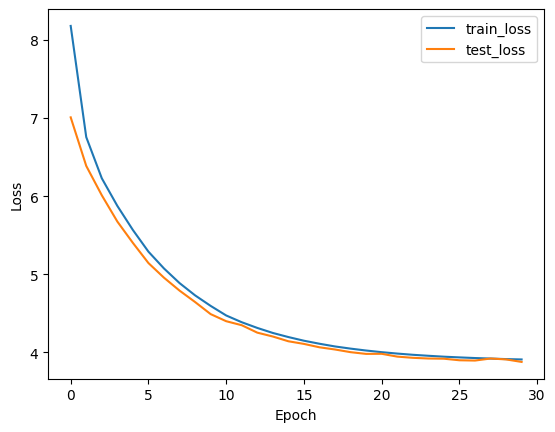

In [8]:
### Plot the loss of three models

plt.plot(train_loss_all, label='train_loss')
plt.plot(test_loss_all, label='test_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
### output the prediction

y_pre_re = model(X_test_final.to(device))
y_pre_re = y_pre_re.cpu().data.numpy()


In [10]:
### save the results for visualization

scipy.io.savemat('./down_data/model_re_v5_3199.mat', {'model_re_v5_3199':y_pre_re.T})
# scipy.io.savemat('./data_nature/model_lr.mat', {'model_lr':y_pre_lr.T})
# scipy.io.savemat('./data_nature/model_sm.mat', {'model_sm':y_pre_sm.T})
scipy.io.savemat('./down_data/test_3model_v5.mat', {'test_3model_v5':y_test.T})

### XGBOOST

In [23]:
model = xgb.XGBRegressor()
model.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
y_pred = model.predict(X_test_final)


In [25]:
y_pred.shape

(1500, 249)

In [26]:
scipy.io.savemat('./down_data/xgb_down_data_v2.mat', {'xgb_down_data_v2':y_pred.T})